# Trabalho prático da disciplina SCC0230 - Inteligência Artificial
### Orientadora: profª Draª Solange Oliveira Rezende

### Arthur Hiratsuka Rezende - 13687108
### Caio
### Gustavo
### João


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st

from heapq import heappop, heappush
from itertools import count

from datetime import timedelta
from haversine import haversine

import networkx as nx
from networkx.algorithms.shortest_paths.weighted import _weight_function

import time
import math


def apply_haversine(data : 'dataframe'):
    df = data.copy()
    from haversine import haversine
    for i in range(len(df) - 1):
        coord_a = (df.pos_X[i], df.pos_Y[i])
        coord_b = (df.pos_X[i + 1], df.pos_Y[i + 1])
        df.loc[[i],['weight']] = haversine(coord_a, coord_b)
        
    return df

In [2]:
# Funções interface usuário

def menu_user():
    input_menu = get_input(df)
    orig_input = df['label_source'].loc[df['source'] == input_menu[0]].iloc[0]
    dest_input = df['label_source'].loc[df['source'] == input_menu[1]].iloc[0] 
    best_path(G_calc, df, orig_input, dest_input)


def get_input(df : 'dataframe') -> list:
    input_user = []
    print('Não utilize acentos/caracteres especiais')
    str_input = ''
    flag = 0
    while flag == 0:
        str_input = input('Insira a estação de origem : ').upper()
        flag = len(df.loc[df['source'] == str_input])
        if (flag == 0):
            print("Estação inválida!")
    input_user.append(str_input)
    
    str_input = ''
    flag = 0
    while flag == 0:
        str_input = input('Insira a estação de destino : ').upper()
        # utilizada busca na coluna 'source' pois ela abrange todos os casos
        # ao contrário da coluna 'target'
        flag = len(df.loc[df['source'] == str_input])
        if (flag == 0):
            print("Estação inválida!")
    input_user.append(str_input)
    return input_user


def get_time(sec):
    td_str = str(timedelta(seconds=sec))
    x = td_str.split(':')
    print('\nDuração aproximada do trajeto', x[0], 'horas', x[1], 'minutos', x[2], 'segundos')

def best_path(graph_data : 'graph', dataframe : 'dataframe', origin : str, destination : str):
    path_nodes = nx.shortest_path(graph_data, origin, destination, weight = "weight")
    path_lenght = nx.shortest_path_length(graph_data, origin, destination, weight = "weight")
    aux_troca = 0
    aux_index = 0
    bkp_index = 0
    
    est0 = path_nodes[0].split('-')
    est1 = path_nodes[1].split('-')

    if(est0[0] == est1[0]):
        aux_troca = -1
        aux_index = 1
        bkp_index = 1
    
    key_list = []
    for i in range(len(path_nodes) - 1):
        key = list(graph_data.get_edge_data(path_nodes[i],path_nodes[i + 1]))
        key_list.append(key[0])

    aux_key = key_list[0]
    aux_flag = 0
     
    print('\n\nItinerário resumido:')    
    print(f"{'Embarque na linha:': <25} {key_list[aux_index]: <20} {'Estação:': <10} {path_nodes[aux_index].split('-')[0] : <25}")
    
    for aux_index in range(len(path_nodes) - 1):
        if (aux_flag == 0) and (aux_key != key_list[aux_index]):
            print(f"{'Baldeação para linha:': <25} {key_list[aux_index]: <20} {'Estação:': <10} {path_nodes[aux_index].split('-')[0] : <25}")
            aux_flag = 1
            
        aux_key = key_list[aux_index]
        aux_flag = 0  
        
    print(f"{'Desembarque na linha:': <25} {key_list[-1]: <20} {'Estação:': <10} {path_nodes[-1].split('-')[0] : <25}")
    
    # 30 segundos por parada (metro)
    # 3 minutos baldeação
    # 40km/h velocidade média metro
    
    eta_seconds = ((path_lenght*3600)/40) + ((len(path_nodes) - 1)*30) + (aux_troca * 180)
    print("DISTANCIA ESTIMADA DO TRAJETO:", path_lenght)
    get_time(int(eta_seconds))
    
    print("\nItinerário descriminado:")
    for bkp_index in range(len(path_nodes) - 1):
        if(path_nodes[bkp_index].split('-')[0] != path_nodes[bkp_index + 1].split('-')[0]):
            print(f"{'Linha:   ' +  key_list[bkp_index]: <30} {'Estação:   ' + path_nodes[bkp_index].split('-')[0] : <40} -> {'Estação:   ' + path_nodes[bkp_index + 1].split('-')[0] : <30} ")
        else:
            print(f"\n{'MUDANÇA DE LINHAS NA ESTAÇÃO:   ' + path_nodes[bkp_index].split('-')[0] : <45} {'Linha de origem: ' +  key_list[bkp_index - 1]: <25} ---> {'Linha destino: ' +  key_list[bkp_index + 1]: <30}")

    key_unique = []
    for key in key_list:
        if key not in key_unique:
            key_unique.append(key)
    
    nodes_list = []
    for node in path_nodes:
        aux_str = node.split('-')[0]
        if aux_str not in nodes_list:
            nodes_list.append(aux_str)
    
    plt.figure(figsize = (30,30))
    for elem in key_unique:
        key = elem.split('-')[-1]
        df_edges_aux = df_dict[key][["source", "target", "weight", "label_edge"]]
        df_edges = df_edges_aux.loc[(df_edges_aux['source'].isin(nodes_list)) & (df_edges_aux['target'].isin(nodes_list))]
        
        df_nodes = df_dict[key][["source", "pos_X", "pos_Y"]]

        g_col = nx.from_pandas_edgelist(df_edges, source = 'source', target = 'target', edge_attr = 'weight')

        nx.draw_networkx(g_col,
                         pos = position_map,
                         with_labels = True,
                         node_size=500, 
                         node_shape = '8',
                         node_color = colour_dict.get(key), 
                         style = 'dashed',
                         font_size = 20)

In [3]:
# Algoritmo A*

def a_estrela(G, source, target, weight="weight"):
    
    # Função heurística - distância entre dois pontos palicando haversine
## Utiliza lat/long e considera curvatura da terra

    def heuristica(node_A, node_B, df):
        
        coord_a = (0,0)
        coord_b = (0,0)
        flag = 0
    
        try:
            ca_X = df.loc[(df['label_source'] == node_A)]['pos_X'].iloc[0]
            ca_Y = df.loc[(df['label_source'] == node_A)]['pos_Y'].iloc[0]
            coord_a = (ca_X, ca_Y)
        except IndexError:
            ca_X, ca_Y = None, None
            flag = 1
    
        try:
            cb_X = df.loc[(df['label_source'] == node_B)]['pos_X'].iloc[0]
            cb_Y = df.loc[(df['label_source'] == node_B)]['pos_Y'].iloc[0]
            coord_b = (cb_X, cb_Y) 
        except IndexError:
            cb_X, cb_Y = None, None
            flag = -1
            
        if flag == 1 : coord_a = coord_b
        if flag == -1: coord_b = coord_a
        return haversine(coord_a, coord_b)
        
    if (source not in G or target not in G):
        raise NameError('O nó de partida/destino não existe no grafo!')

    # Ações da fila
    push = heappush
    pop = heappop
    weight_func = _weight_function(G, weight)

    counter = count()
    fila = [(0, next(counter), source, 0, None)]

    # Controle dos nós abertos e visitados
    abertos = {} # abertos[nó] = (caminho total ate o no, heuristica)
    visitados = {}

    while fila:
        # atualiza o no atual, a distancia atual e o no anterior a partir da fila
        _, __, no_atual, dist, no_anterior = pop(fila)

        # Condição de parada - achou o destino
        if no_atual == target:
            caminho = [no_atual]
            node = no_anterior
            while node is not None:
                caminho.append(node)
                node = visitados[node]
            caminho.reverse()
            return caminho
        
        # Caso o nó atual já tenha sido visitado
        if no_atual in visitados:

            # Caso especial : primeira chamada
            if visitados[no_atual] is None:
                continue

            custo_abertos, h = abertos[no_atual]
            if custo_abertos < dist:               
                continue

        visitados[no_atual] = no_anterior

        # Para cada vizinho
        for vizinho, w in G[no_atual].items():
            # Compute o custo entre ele e o nó atual
            custo = weight_func(no_atual, vizinho, w)

            if custo is None:
                continue # verificação de custo invalido
                
            custo_novo = dist + custo
            
            if vizinho in abertos:
                custo_abertos, h = abertos[vizinho]
                # Verificação se o custo de um nó já aberto é menor que custo desse nó pelo caminho atual
                ## Caso seja não substitui -  o caminho existente já é melhor
                if custo_abertos <= custo_novo:
                    continue
            else:
                h = heuristica(vizinho, target, df)
            abertos[vizinho] = custo_novo, h
            push(fila, (custo_novo + h, next(counter), vizinho, custo_novo, no_atual))


def a_estrela_distancia(G, source, target, weight="weight"):

    if (source not in G or target not in G):
        raise NameError('O nó de partida/destino não existe no grafo!')

    path = a_estrela(G, source, target, weight)
    weight_func = _weight_function(G, weight)

    total_weight = 0
    for u, v in zip(path[:-1], path[1:]):
        weight_uv = weight_func(u, v, G[u][v])
        total_weight += weight_uv

    return total_weight

In [4]:
# Algoritmo busca profundidade

def dfs_path(G, source, target):
    caminho = None
    pilha = [(source, [source])]
    visitados = []
    
    while pilha:
        no_atual, caminho = pilha.pop(0)
        
        if no_atual == target:
            return caminho
        
        if no_atual not in visitados:
            visitados.append(no_atual)
        
            vizinhos = list(G.neighbors(no_atual))
            for index, vizinho in enumerate(vizinhos):
                if vizinho not in visitados:
                    pilha.insert(index, (vizinho, caminho + [vizinho]))
                                     

def dfs_distancia(G, source, target, weight="weight"):

    if (source not in G or target not in G):
        raise NameError('O nó de partida/destino não existe no grafo!')

    path = dfs_path(G, source, target)
    weight_func = _weight_function(G, weight)

    total_weight = 0
    for u, v in zip(path[:-1], path[1:]):
        weight_uv = weight_func(u, v, G[u][v])
        total_weight += weight_uv

    return total_weight

# Visualização do mapa

In [5]:
# Dicionário de cores para plotagem
colour_dict = {'VERMELHA' : '#FF0F00',
              'VERDE' : '#2EFF00',
              'TURQUESA' : '#00E0FF',
               'SAFIRA' : '#385f8f',
               'RUBI' : '#aa443f',
               'PRATA' : '#c0c0c0',
               'LILAS' : '#c8a2c8',
               'JADE' : '#00A86B',
               'ESMERALDA' : '#50c878',
               'DIAMANTE' : '#b9f2ff',
               'CORAL' : '#ff7f50',
               'AZUL' : '#4169e1',
               'AMARELA' : '#ffff00',
              }

# Variável -> velocidade média do metrô
train_speed = 40

# Tratamento inicial dos dados
## importar e fazer bkp dados
df_raw = pd.read_csv('metroetrem_sp_comlinks.csv')
df_original = df_raw.copy()

## Renomear colunas
df_raw.rename(columns={"estacao_upp": "source", "link": "target", "nome_lin" : "name", "long" : "pos_X", "lat" : "pos_Y"}, inplace = True)

## Criar coluna de peso das arestas
df_raw['weight'] = 0
df_raw = apply_haversine(df_raw)

## Aplicar mapa de cores
df_raw['colour'] = df_raw['name'].map(colour_dict)

## Inserir dados faltantes/Corrigir inconsistências
df_raw.loc[len(df_raw.index)] = [4, 'AMARELA', -46.662161, -23.555044, 'PAULISTA', 'CONSOLACAO', 0.5, '#ffff00']
df_raw.loc[len(df_raw.index)] = [2, 'VERDE', -46.660974, -23.557372, 'CONSOLACAO', 'PAULISTA', 0.5, '##2EFF00']
df_raw.loc[df_raw['source'] == 'PALMEIRAS BARRA FUNDA', 'source'] = 'BARRA FUNDA'

## Criar labels para os nós
### Colunas 'Labels' são utilizadas no cálculo do trajeto
### Colunas 'source & target' são utilizadas na plotagem do trajeto
df_raw['num_lin'] = df_raw['num_lin'].astype('str')
df_raw['label_edge'] = df_raw['num_lin'] + '-' + df_raw['name']
df_raw['label_source'] = df_raw['source'] + '-' + df_raw['num_lin']
df_raw['label_target'] = df_raw['target'] + '-' + df_raw['num_lin']

# df_raw

In [6]:
# Manipulação dos dados para plotagem de cada linha separadamente

## Copiar dados e remover valores nulos/Nan
df_map = df_raw.copy()
df_map.dropna(inplace = True)
df_map.drop(df_map.loc[df_map['weight'] == 0].index, inplace = True)

## Criar dict de posição dos nodes
aux_pos = df_map[["source", "pos_X", "pos_Y"]].copy()
aux_pos.drop_duplicates(subset = ['source'], keep = 'first', inplace = True)
position_map = aux_pos.set_index('source').T.to_dict('list')

## Remover estações duplicadas
df_map.drop(df_map.loc[df_map['source'] == df_map['target']].index, inplace = True)
df_map_bkp = df_map.copy()

## Criar dicionário que cada chave contenha os dados das estações de dada linha
## -> linha : dataframe da linha
linhas_id = df_map.name.unique()
df_dict = {elem : pd.DataFrame() for elem in linhas_id}

## Laço para plotar cada linha
for key in df_dict.keys():
    df_dict[key] = df_map[:][df_map.name == key]
    
    
## Laço para plotar
# for key in df_dict:
#     plt.figure(figsize = (20,5))
#     title = 'Linha ' + df_map['num_lin'].loc[df_map['name'] == key].iloc[0] + '-' + key.capitalize()
#     plt.title(title)
#     df_edges = df_dict[key][["source", "target", "weight"]]
#     df_nodes = df_dict[key][["source", "pos_X", "pos_Y"]]
# 
#     g_key = nx.from_pandas_edgelist(df_edges, source = 'source', target = 'target', edge_attr = 'weight')
# 
#     nx.draw_networkx(g_key,
#                      pos = position_map,
#                      with_labels = True,
#                      node_size=75, 
#                      node_shape = '8',
#                      node_color = colour_dict.get(key), 
#                      style = 'dashed',
#                      font_size = 7)

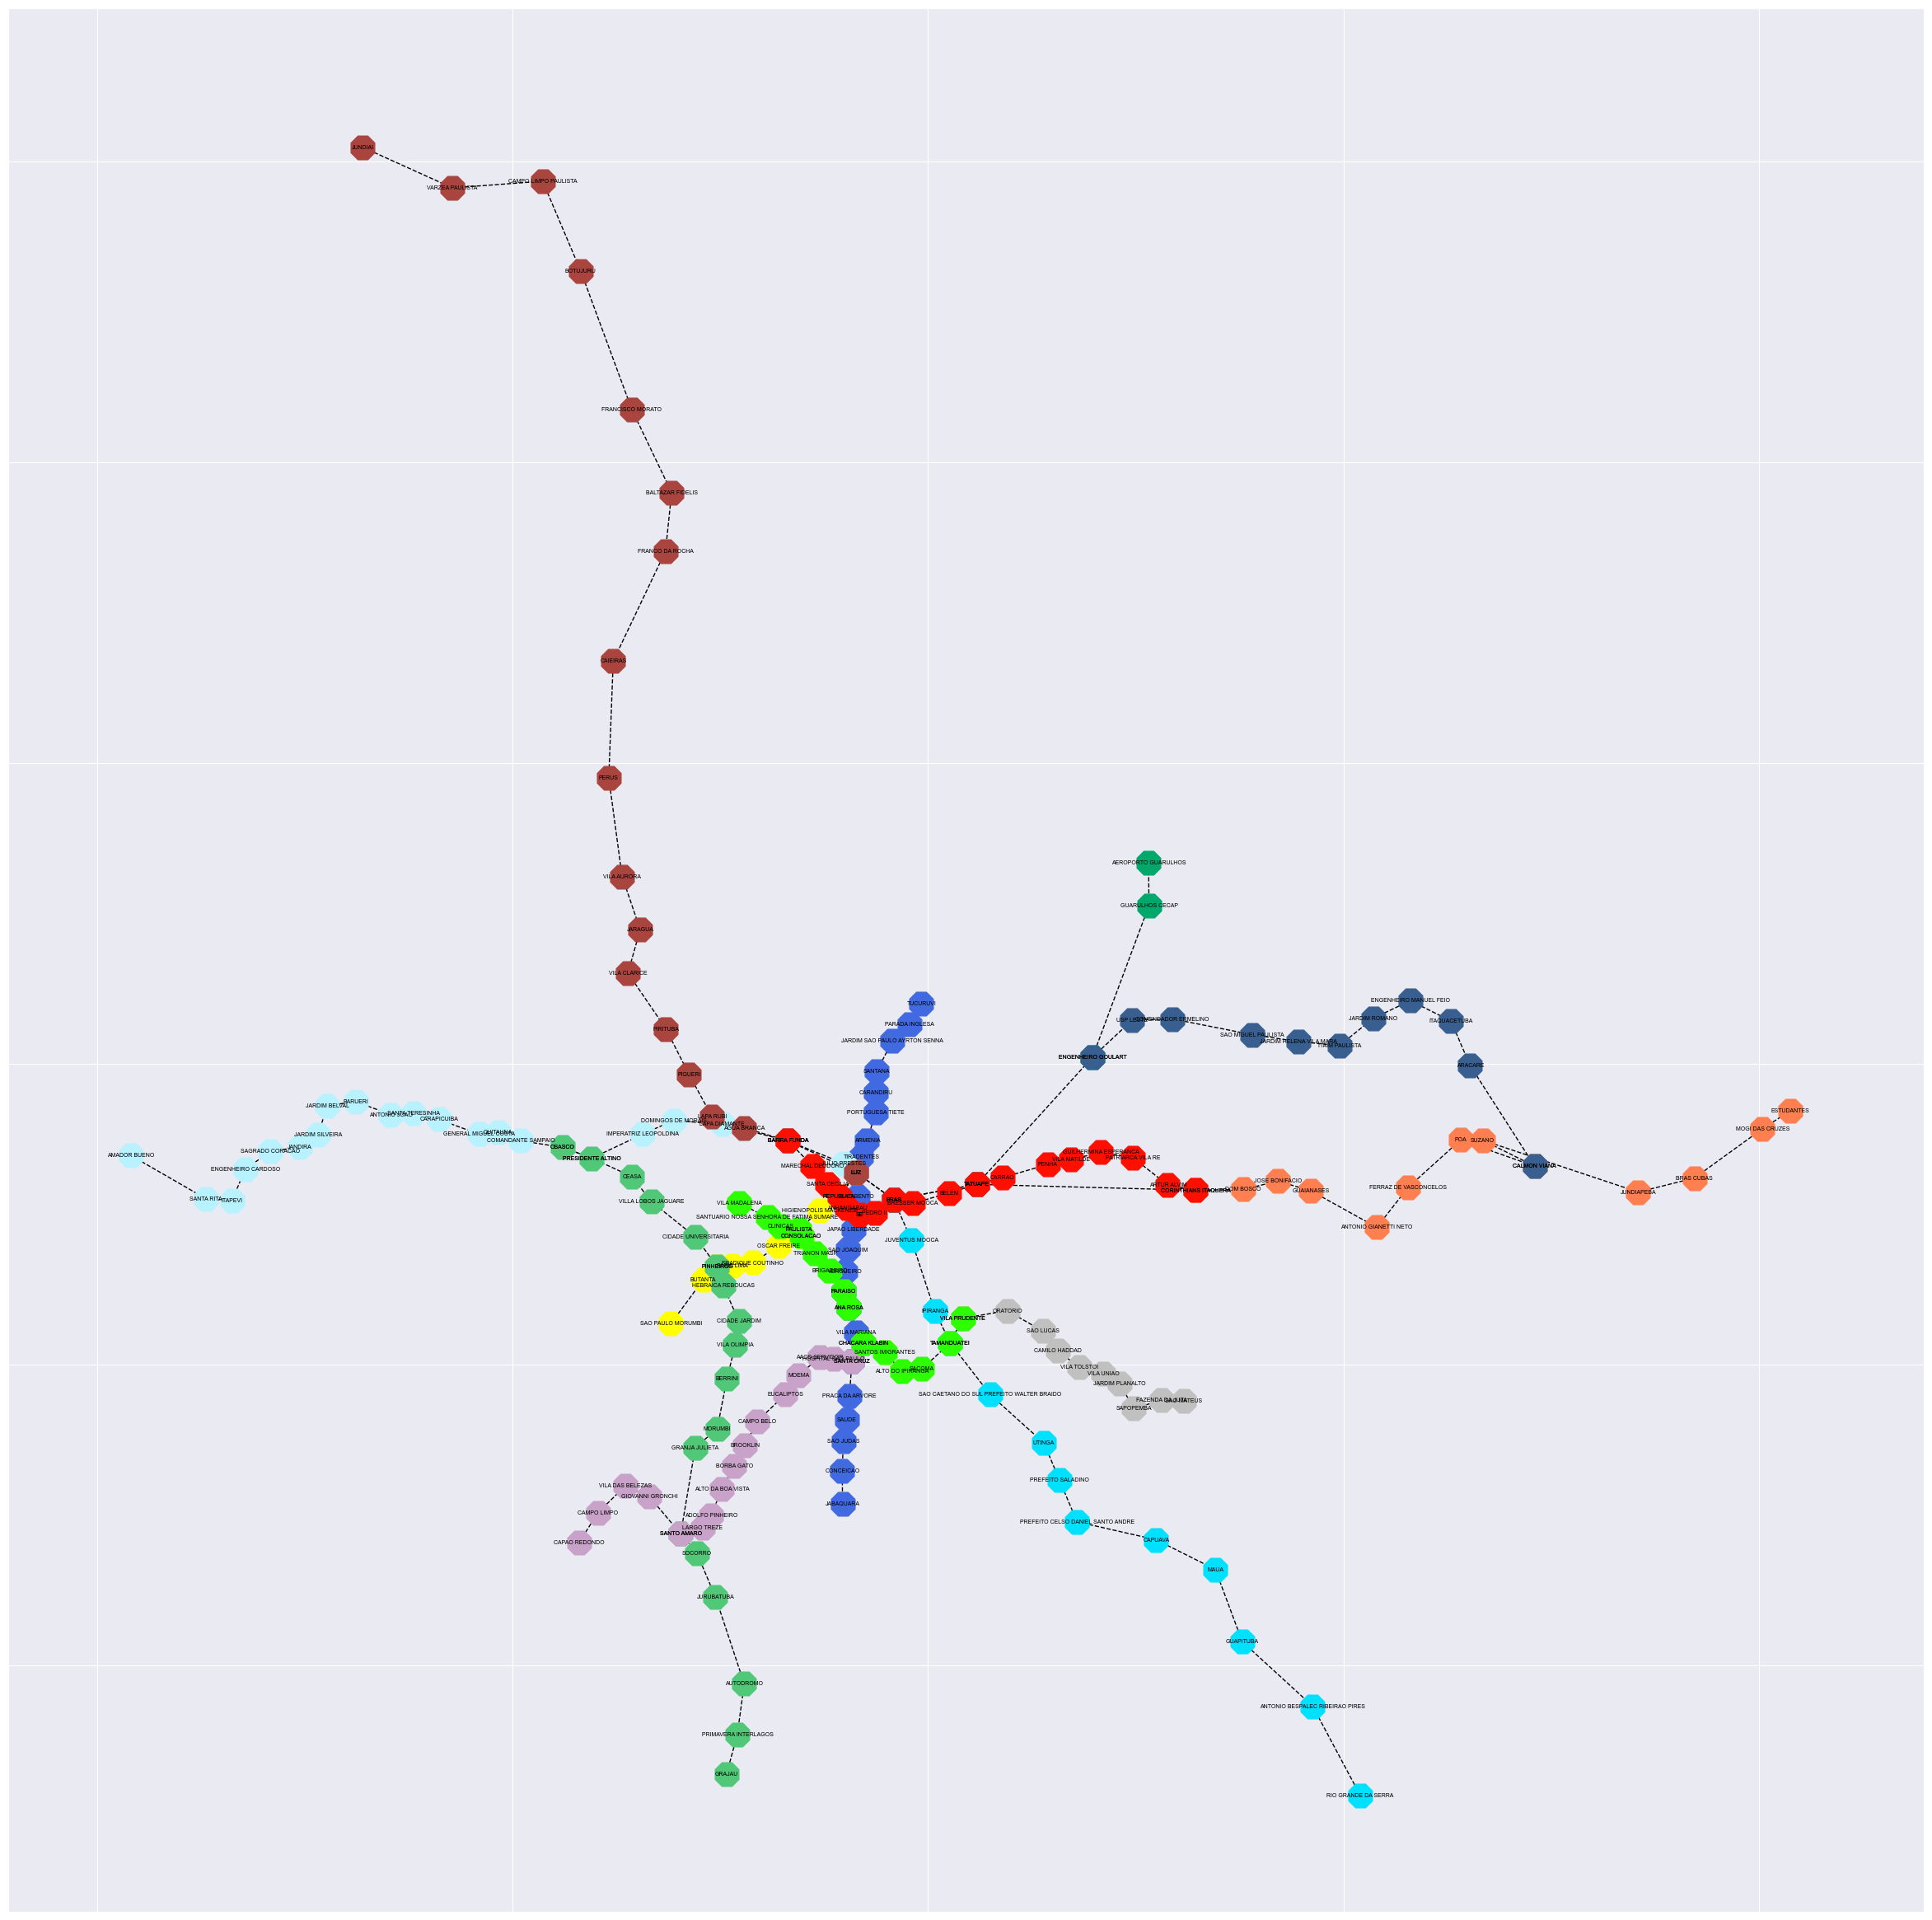

In [7]:
# Manipulação dos dados para plotagem de malha inteira

plt.figure(figsize = (30,30))
for key in df_dict:
    df_edges = df_dict[key][["source", "target", "weight"]]
    df_nodes = df_dict[key][["source", "pos_X", "pos_Y"]]

    g_full = nx.from_pandas_edgelist(df_edges, source = 'source', target = 'target', edge_attr = 'weight')
    nx.draw_networkx(g_full,
                     pos = position_map,
                     with_labels = True,
                     node_size=500, 
                     node_shape = '8',
                     node_color = colour_dict.get(key), 
                     style = 'dashed',
                     font_size = 5)
    
# plt.savefig("malha_full.png")

# Manipulação dos dados para os cálculos de melhor trajeto

In [8]:
## Adicionar estações que fazem conexão com mais de uma linha (baldeação)

## Criar dataframe que recebe estações que tem baldeação
columns_list = df_raw.columns.values.tolist()
df_baldea = pd.DataFrame(columns = columns_list)

## Copiar as estações que são 'source'/origem de mais de um trajeto
df_aux = df_raw[df_raw.duplicated('source')].sort_values('source')
bald_list = df_aux['source'].unique()

## Preencher o dataframe com conexões entre a mesma estação mas entre diferentes linhas (e.g. Luz-Azul -> Luz-Coral)
for elem in bald_list:
    slice_bald = df_raw.loc[df_raw['source'] == elem]   
    for i in range(len(slice_bald)):
        for j in range(i + 1, len(slice_bald)):
            df_baldea.loc[len(df_baldea.index)] = [slice_bald.iloc[i][0],
                                                   slice_bald.iloc[i][1],
                                                   slice_bald.iloc[i][2],
                                                   slice_bald.iloc[i][3],
                                                   slice_bald.iloc[i][4],
                                                   slice_bald.iloc[i][4],
                                                   (train_speed/12),
                                                   slice_bald.iloc[i][7],
                                                   slice_bald.iloc[i][8],
                                                   slice_bald.iloc[i][9],
                                                   slice_bald.iloc[j][9]]

            
## Concatenar o dataframe original com o que contem as baldeações
# display(df_baldea)
df = pd.concat([df_raw, df_baldea]).sort_values('num_lin').reset_index(drop= True)
df = df.reindex(index = df.index[::-1])

df.dropna(inplace = True)
df.drop(df.loc[df['weight'] == 0].index, inplace = True)


## Criar um dict de posição dos nodes (source e target)
aux_pos_source = df[["label_source", "pos_X", "pos_Y"]].copy()
aux_pos_target = df[["label_target", "pos_X", "pos_Y"]].copy()

aux_pos_source = aux_pos_source.drop_duplicates()
aux_pos_target = aux_pos_target.drop_duplicates()

position_source = aux_pos_source.set_index('label_source').T.to_dict('list')
position_target = aux_pos_target.set_index('label_target').T.to_dict('list')

position = position_source.copy()
position.update(position_target)

## Criar o grafo utilizado para cálculo de trajeto
G_calc = nx.from_pandas_edgelist(df, source = 'label_source', target = 'label_target', edge_attr = 'weight', create_using = nx.MultiGraph, edge_key = 'label_edge')

C:\Users\arthu\AppData\Local\Temp\ipykernel_4988\1662994895.py:46: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  position_target = aux_pos_target.set_index('label_target').T.to_dict('list')


In [9]:
caminho = a_estrela(G_calc, 'SUZANO-11', 'LUZ-7')
caminho

['SUZANO-11',
 'CALMON VIANA-11',
 'POA-11',
 'FERRAZ DE VASCONCELOS-11',
 'ANTONIO GIANETTI NETO-11',
 'GUAIANASES-11',
 'JOSE BONIFACIO-11',
 'DOM BOSCO-11',
 'CORINTHIANS ITAQUERA-11',
 'TATUAPE-11',
 'BRAS-11',
 'BRAS-7',
 'LUZ-7']

In [10]:
a_estrela_distancia(G_calc, 'SUZANO-11', 'LUZ-7')

43.48202184318695

In [11]:
dfs_path(G_calc, 'SUZANO-11', 'LUZ-7')

['SUZANO-11',
 'CALMON VIANA-11',
 'POA-11',
 'FERRAZ DE VASCONCELOS-11',
 'ANTONIO GIANETTI NETO-11',
 'GUAIANASES-11',
 'JOSE BONIFACIO-11',
 'DOM BOSCO-11',
 'CORINTHIANS ITAQUERA-11',
 'TATUAPE-11',
 'TATUAPE-12',
 'BRAS-12',
 'BRAS-7',
 'LUZ-7']

In [12]:
dfs_distancia(G_calc, 'SUZANO-11', 'LUZ-7')

46.82369488054187

In [13]:
df.head()

,num_lin,name,pos_X,pos_Y,source,target,weight,colour,label_edge,label_source,label_target
236,9,ESMERALDA,-46.691768,-23.723037,PRIMAVERA INTERLAGOS,AUTODROMO,1.336839,#50c878,9-ESMERALDA,PRIMAVERA INTERLAGOS-9,AUTODROMO-9
235,9,ESMERALDA,-46.761937,-23.531395,PRESIDENTE ALTINO,OSASCO,1.579858,#50c878,9-ESMERALDA,PRESIDENTE ALTINO-9,OSASCO-9
234,9,ESMERALDA,-46.696759,-23.604711,BERRINI,VILA OLIMPIA,0.956831,#50c878,9-ESMERALDA,BERRINI-9,VILA OLIMPIA-9
233,9,ESMERALDA,-46.692763,-23.593600,VILA OLIMPIA,CIDADE JARDIM,0.642687,#50c878,9-ESMERALDA,VILA OLIMPIA-9,CIDADE JARDIM-9
232,9,ESMERALDA,-46.712035,-23.627637,GRANJA JULIETA,MORUMBI,1.268507,#50c878,9-ESMERALDA,GRANJA JULIETA-9,MORUMBI-9


In [14]:
index = np.random.randint(0, len(df))
df.iloc[index]

num_lin                    11
name                    CORAL
pos_X              -46.184967
pos_Y              -23.515735
source             ESTUDANTES
target             ESTUDANTES
weight               88.82361
colour                #ff7f50
label_edge           11-CORAL
label_source    ESTUDANTES-11
label_target    ESTUDANTES-11
Name: 67, dtype: object

In [15]:
G_calc.get_edge_data('PRIMAVERA INTERLAGOS-9', 'AUTODROMO-9',)

{'9-ESMERALDA': {'weight': 1.3368393880619966}}

In [16]:
G_calc['PRIMAVERA INTERLAGOS-9']['AUTODROMO-9']

AtlasView({'9-ESMERALDA': {'weight': 1.3368393880619966}})

In [17]:
# menu_user()

In [18]:
index = np.random.randint(0, len(df))
df.iloc[index]

num_lin                       2
name                      VERDE
pos_X                -46.589733
pos_Y                 -23.59297
source              TAMANDUATEI
target            VILA PRUDENTE
weight                 1.104375
colour                  #2EFF00
label_edge              2-VERDE
label_source      TAMANDUATEI-2
label_target    VILA PRUDENTE-2
Name: 110, dtype: object

In [49]:
class Experiment():  
    def __init__(self, Graph, Dataframe):
        self.df_result = pd.DataFrame(columns=['path_AStar', 'len_AStar', 'dist_AStar', 'time_AStar',
                                               'path_dfs', 'len_dfs', 'dist_dfs', 'time_dfs',
                                               'path_djk', 'len_djk', 'dist_djk', 'time_djk',
                                               'path_hrt', 'len_hrt', 'dist_hrt', 'time_hrt'
                                               ])
        self.G = Graph
        self.df = Dataframe

    def heuristica(self, node_A, node_B, euclidiana = True):
        
        coord_a = (0,0)
        coord_b = (0,0)
        flag = 0
    
        try:
            ca_X = self.df.loc[(self.df['label_source'] == node_A)]['pos_X'].iloc[0]
            ca_Y = self.df.loc[(self.df['label_source'] == node_A)]['pos_Y'].iloc[0]
            coord_a = (ca_X, ca_Y)
        except IndexError:
            flag = 1
    
        try:
            cb_X = self.df.loc[(self.df['label_source'] == node_B)]['pos_X'].iloc[0]
            cb_Y = self.df.loc[(self.df['label_source'] == node_B)]['pos_Y'].iloc[0]
            coord_b = (cb_X, cb_Y) 
        except IndexError:
            flag = -1
            
        if flag == 1 : coord_a = coord_b
        if flag == -1: coord_b = coord_a

        if euclidiana : return math.dist(coord_a, coord_b)
        else: return haversine(coord_a, coord_b)
    

    
    def elapsed_time(self, n_rep = 10):  
        # Define source/target
        idx_s = np.random.randint(0, len(self.df))
        source = self.df.iloc[idx_s]['label_source']
        
        idx_t = np.random.randint(0, len(df))
        while (idx_s == idx_t): idx_t = np.random.randint(0, len(df))
        target = self.df.iloc[idx_t]['label_target']
        
        # A* time measure
        a_time = []
        for i in range (n_rep):
            start_time = time.perf_counter()
            path_AStar = list(a_estrela(self.G, source, target))
            dist_AStar = a_estrela_distancia(self.G, source, target)
            end_time = time.perf_counter()
            time_AStar = end_time - start_time
            a_time.append(time_AStar)
        
        # DFS time measure
        dfs_time = []
        for i in range (n_rep):
            start_time = time.perf_counter()
            path_dfs = list(dfs_path(self.G, source, target))
            dist_dfs = dfs_distancia(self.G, source, target)
            end_time = time.perf_counter()
            time_dfs = end_time - start_time
            dfs_time.append(time_dfs)
            
         # Heuristic time measure
        hrt_time = []
        for i in range (n_rep):
            start_time = time.perf_counter()
            path_hrt = list(nx.astar_path(self.G, source, target, heuristic=self.heuristica))
            dist_hrt = nx.astar_path_length(self.G, source, target, heuristic=self.heuristica)
            end_time = time.perf_counter()
            time_hrt = end_time - start_time
            hrt_time.append(time_hrt)
            
        # Dijkstra time measure
        djk_time = []
        for i in range (n_rep):
            start_time = time.perf_counter()
            path_djk = list(nx.dijkstra_path(self.G, source, target))
            dist_djk = nx.dijkstra_path_length(self.G, source, target)
            end_time = time.perf_counter()
            time_djk = end_time - start_time
            djk_time.append(time_djk)
            
        def avg(lista):
            return sum(lista)/len(lista)
        
        return [path_AStar, len(path_AStar), dist_AStar, avg(a_time),
                path_dfs, len(path_dfs), dist_dfs, avg(dfs_time),
                path_djk, len(path_djk), dist_djk, avg(djk_time),
                path_hrt, len(path_hrt), dist_hrt, avg(hrt_time),
        ]
    
    def run_experiment(self, n_exp, n_rep):
        start_time = time.time()
        for exp in range(n_exp):
            experiment = self.elapsed_time(n_rep)
            self.df_result.loc[len(self.df_result)] = experiment
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Tempo total do experimento: {elapsed_time}s")
        self.df_result['delta_tempo'] = self.df_result['time_AStar'] - self.df_result['time_dfs']
        self.df_result['delta_len'] = self.df_result['len_AStar'] - self.df_result['len_dfs']
        self.df_result['delta_dist'] = self.df_result['dist_AStar'] - self.df_result['dist_dfs']
        
        self.df_result['delta_tempoHeur'] = self.df_result['time_AStar'] - self.df_result['time_hrt']
        self.df_result['delta_lenHeur'] = self.df_result['len_AStar'] - self.df_result['len_hrt']
        self.df_result['delta_distHeur'] = self.df_result['dist_AStar'] - self.df_result['dist_hrt']
        

In [58]:
teste = Experiment(Graph= G_calc, Dataframe = df)
teste.run_experiment(n_exp=2500, n_rep=5)

df_obs = teste.df_result
df_obs.describe()

Tempo total do experimento: 2189.001127719879s


,len_AStar,dist_AStar,time_AStar,len_dfs,dist_dfs,time_dfs,len_djk,dist_djk,time_djk,len_hrt,dist_hrt,time_hrt,delta_tempo,delta_len,delta_dist,delta_tempoHeur,delta_lenHeur,delta_distHeur
count,2500.00000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.0,2500.0
mean,15.51320,27.181281,0.059918,28.08840,54.844652,0.000527,15.51320,27.181281,0.000418,15.51320,27.181281,0.113816,0.059391,-12.575200,-27.663371,-0.053898,0.0,0.0
std,7.68327,16.758786,0.038643,16.09219,31.443870,0.000422,7.68327,16.758786,0.000256,7.68327,16.758786,0.065801,0.038590,13.989948,27.563444,0.040088,0.0,0.0
min,1.00000,0.000000,0.000004,1.00000,0.000000,0.000002,1.00000,0.000000,0.000001,1.00000,0.000000,0.000004,0.000002,-56.000000,-118.090721,-0.263815,0.0,0.0
25%,10.00000,13.938247,0.028578,15.00000,30.043856,0.000157,10.00000,13.938247,0.000199,10.00000,13.938247,0.056876,0.027883,-21.000000,-45.548084,-0.079930,0.0,0.0
50%,15.00000,24.290057,0.053085,26.00000,51.187004,0.000435,15.00000,24.290057,0.000404,15.00000,24.290057,0.111788,0.052613,-8.000000,-18.962728,-0.045719,0.0,0.0
75%,21.00000,37.542114,0.085628,41.00000,78.902634,0.000847,21.00000,37.542114,0.000627,21.00000,37.542114,0.169585,0.085022,0.000000,-3.341673,-0.021830,0.0,0.0
max,42.00000,95.327781,0.216025,74.00000,143.045498,0.004643,42.00000,95.327781,0.001439,42.00000,95.327781,0.312526,0.215665,9.000000,0.000000,0.021793,0.0,0.0


In [59]:
len(df_obs.loc[df_obs['delta_dist']==0])/len(df_obs), df_obs["time_AStar"].max()/df_obs["time_dfs"].max()

(0.1756, 46.52719589692729)

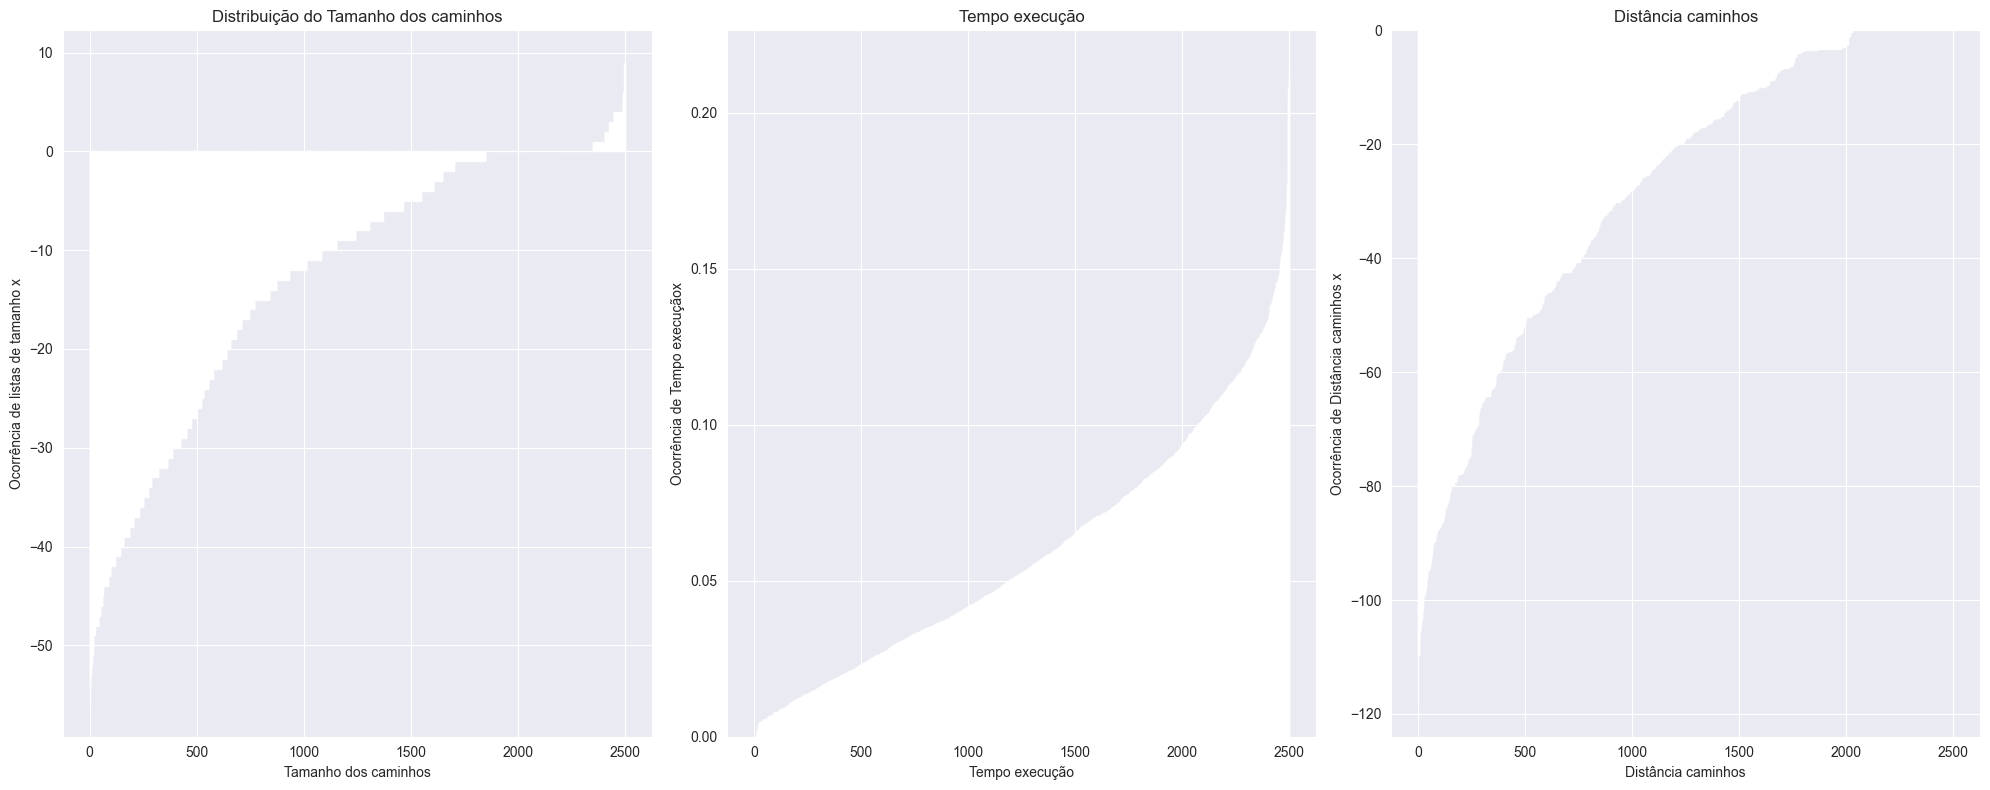

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

df_ord = df_obs.sort_values(by='delta_len').reset_index().copy()
axes[0].bar(df_ord.index, df_ord['delta_len'])
axes[0].set_xlabel('Tamanho dos caminhos')
axes[0].set_ylabel('Ocorrência de listas de tamanho x')
axes[0].set_title(f'Distribuição do Tamanho dos caminhos')

df_ord = df_obs.sort_values(by='delta_tempo').reset_index().copy()
axes[1].bar(df_ord.index, df_ord['delta_tempo'])
axes[1].set_xlabel('Tempo execução')
axes[1].set_ylabel('Ocorrência de Tempo execuçãox')
axes[1].set_title(f'Tempo execução')

df_ord = df_obs.sort_values(by='delta_dist').reset_index().copy()
axes[2].bar(df_ord.index, df_ord['delta_dist'])
axes[2].set_xlabel('Distância caminhos')
axes[2].set_ylabel('Ocorrência de Distância caminhos x')
axes[2].set_title(f'Distância caminhos')

plt.tight_layout()

plt.show()

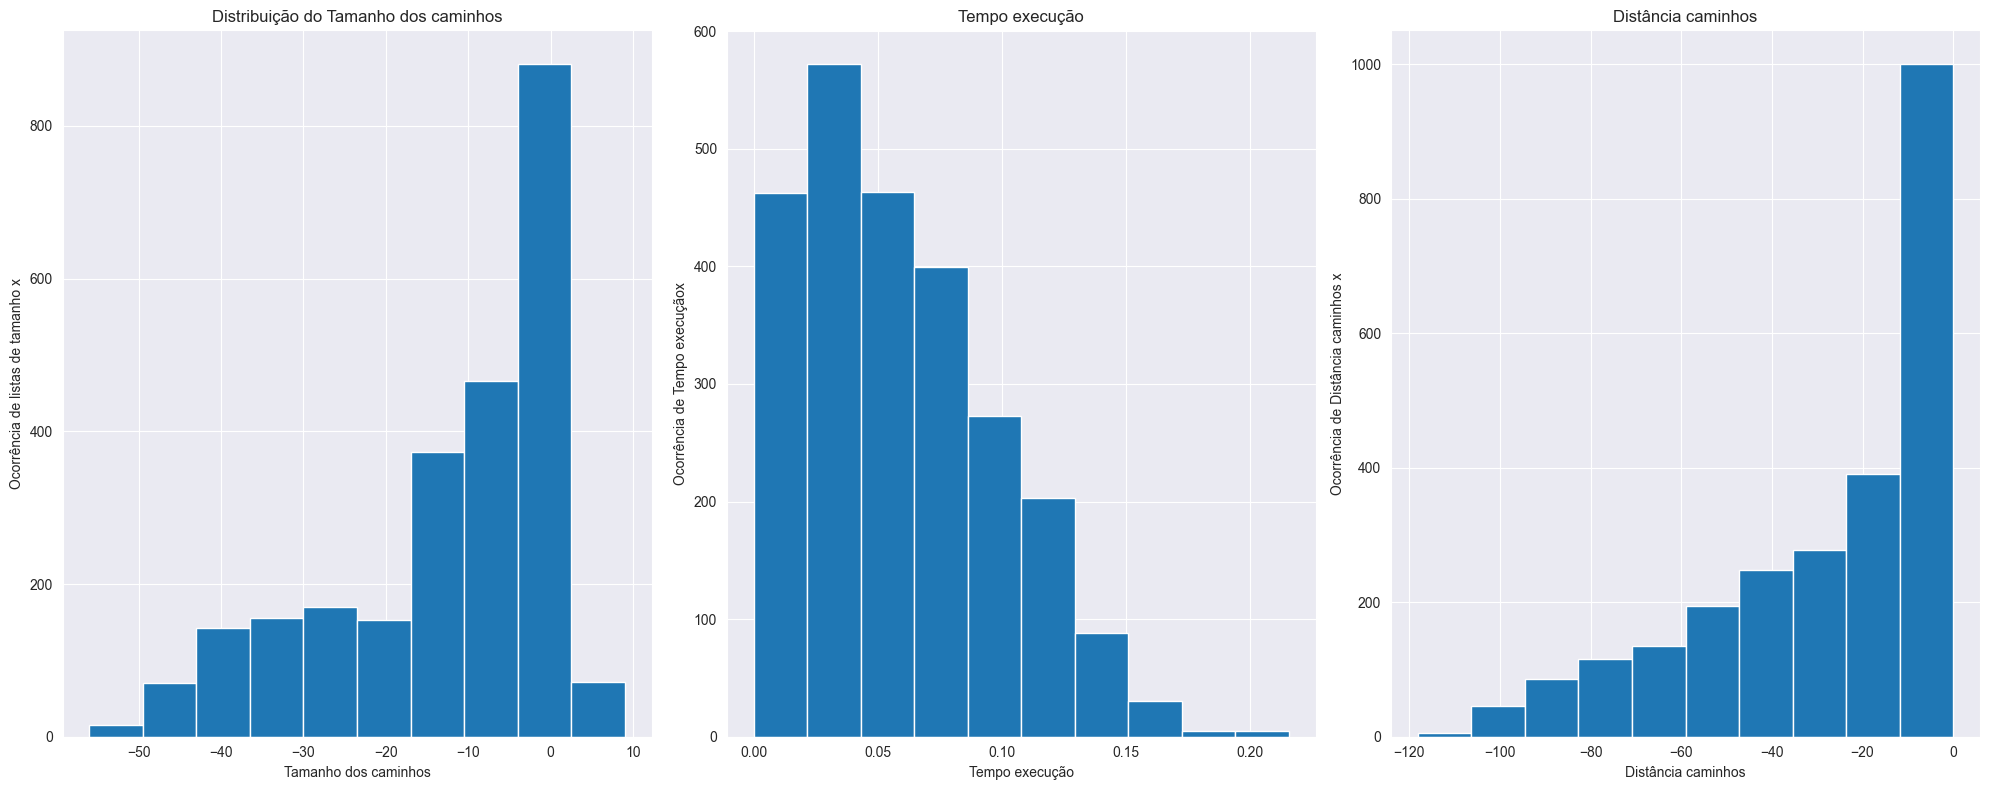

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
axes[0].hist(df_obs['delta_len'], bins=10)
axes[0].set_xlabel('Tamanho dos caminhos')
axes[0].set_ylabel('Ocorrência de listas de tamanho x')
axes[0].set_title(f'Distribuição do Tamanho dos caminhos')

axes[1].hist(df_obs['delta_tempo'], bins=10)
axes[1].set_xlabel('Tempo execução')
axes[1].set_ylabel('Ocorrência de Tempo execuçãox')
axes[1].set_title(f'Tempo execução')

axes[2].hist(df_obs['delta_dist'], bins=10)
axes[2].set_xlabel('Distância caminhos')
axes[2].set_ylabel('Ocorrência de Distância caminhos x')
axes[2].set_title(f'Distância caminhos')

plt.tight_layout()

plt.show()

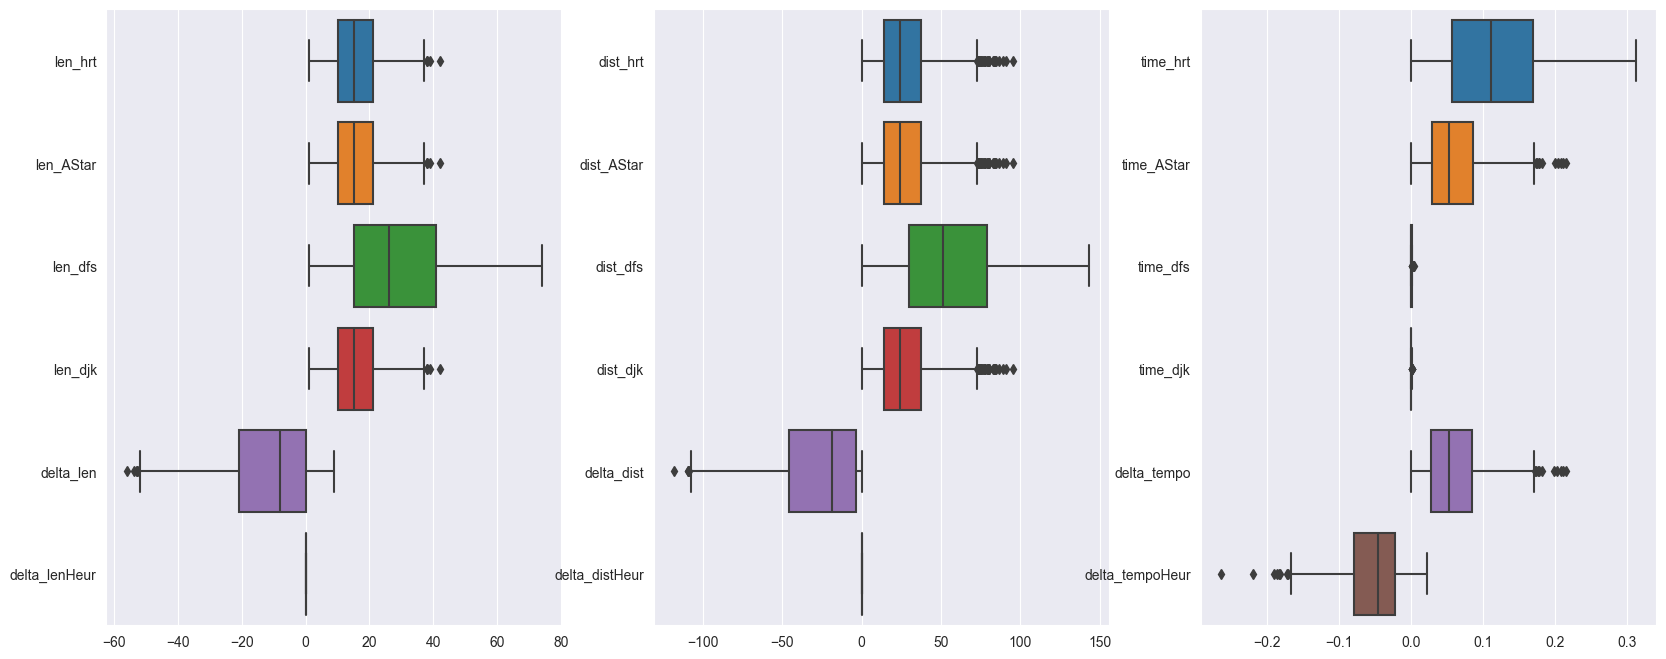

In [62]:
fig, axs = plt.subplots(1,3, figsize=(20,8))

variable_plot = [["len_hrt", "len_AStar", "len_dfs", "len_djk", "delta_len", "delta_lenHeur"],
                 ["dist_hrt", "dist_AStar", "dist_dfs", "dist_djk", "delta_dist", "delta_distHeur"],
                 ["time_hrt", "time_AStar", "time_dfs","time_djk", "delta_tempo", "delta_tempoHeur"]]

# variable_plot = [["len_AStar", "len_dfs", "delta_len"], ["dist_AStar", "dist_dfs", "delta_dist"],
#                  ["time_AStar", "time_dfs", "delta_tempo"]]
for i in range (3):
    ax = axs[i]
    
    sns.boxplot(data=df_obs[variable_plot[i]], orient='horizontal', ax=ax)

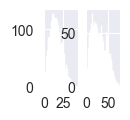

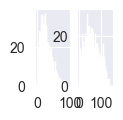

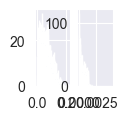

In [63]:
lista_prefixo = ["len_", "dist_", "time_"]
lista_sufixo = ["AStar", "dfs"]
range_axis = [[], [], []]

for j, col in enumerate(lista_prefixo):
    fig, axs = plt.subplots(1,2, figsize=(1,1))    
    for i, sufixo in enumerate(lista_sufixo):
        ax = axs[i]
        ax.hist(data = df_obs, x=col + sufixo, bins=250)
        limx = ax.get_xlim()
        limy = ax.get_ylim()
        range_axis[j].append((limx, limy))

Variavel len_	p-valor = 0.000000000000000
Variavel dist_	p-valor = 0.000000000000000
Variavel time_	p-valor = 0.000000000000000


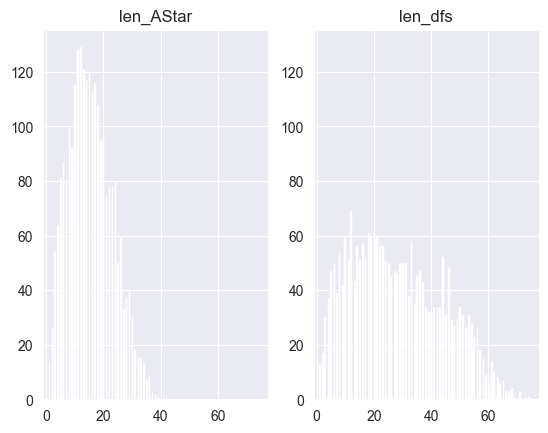

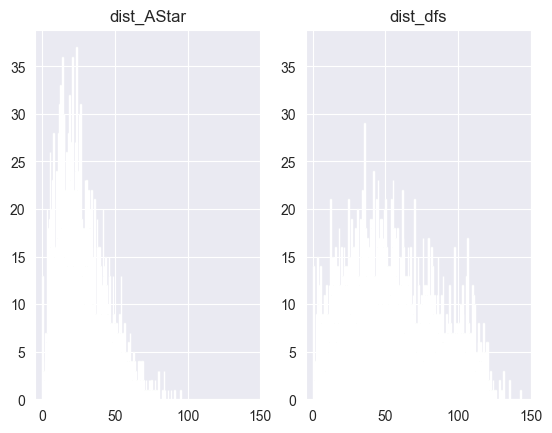

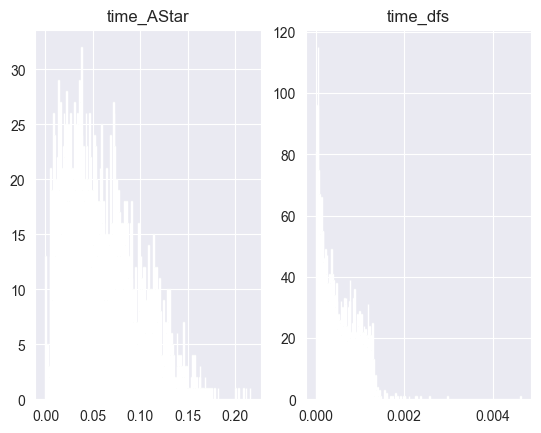

In [69]:
len_x = (max(range_axis[0][0][0][0], range_axis[0][1][0][0]), max(range_axis[0][0][0][1], range_axis[0][1][0][1]))
len_y = (max(range_axis[0][0][1][0], range_axis[0][1][1][0]), max(range_axis[0][0][1][1], range_axis[0][1][1][1]))

dist_x = (max(range_axis[1][0][0][0], range_axis[1][1][0][0]), max(range_axis[1][0][0][1], range_axis[1][1][0][1]))
dist_y = (max(range_axis[1][0][1][0], range_axis[1][1][1][0]), max(range_axis[1][0][1][1], range_axis[1][1][1][1]))

time_x = (max(range_axis[2][0][0][0], range_axis[2][1][0][0]), max(range_axis[2][0][0][1], range_axis[2][1][0][1]))
time_y = (max(range_axis[2][0][1][0], range_axis[2][1][1][0]), max(range_axis[2][0][1][1], range_axis[2][1][1][1]))


for col in lista_prefixo:
    fig, axs = plt.subplots(1,2)    
    for i, sufixo in enumerate(lista_sufixo):
        ax = axs[i]
        
        
        if col == "len_":
            ax.set_xlim(len_x[0], len_x[1])
            ax.set_ylim(len_y[0], len_y[1])
        elif col == "dist_":
            ax.set_xlim(dist_x[0], dist_x[1])
            ax.set_ylim(dist_y[0], dist_y[1])
        # else:
        #     ax.set_xlim(time_x[0], time_x[1])
        #     ax.set_ylim(time_y[0], time_y[1])
        
        ax.hist(data = df_obs, x=col + sufixo, bins=250, color='green')
        ax.title.set_text(col + sufixo)

    _, p_value = st.mannwhitneyu(x=df_obs[col+lista_sufixo[0]], y=df_obs[col+lista_sufixo[1]])
    print(f"Variavel {col}\tp-valor = {p_value:.15f}")

In [ ]:
dfs_path(G_calc, 'SUZANO-11', 'LUZ-7')

In [ ]:
nx.dijkstra_path(G_calc, 'SUZANO-11', 'LUZ-7'), nx.dijkstra_path_length(G_calc, 'SUZANO-11', 'LUZ-7')

In [ ]:
nx.bellman_ford_path(G_calc, 'SUZANO-11', 'LUZ-7'), nx.bellman_ford_path_length(G_calc, 'SUZANO-11', 'LUZ-7')